# Corporate sentiment

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from skfin.plot import bar, line
from tqdm.auto import tqdm

In this section, we describe two strategies to measure sentiment in text. A first strategy is based a dictionary of positive and negative words: simple word counts capture the polarity of the document. A second strategy relies on fitting a linear model with target as returns and features as word counts: in this case, the sign and amplitude of the learned coefficients is used to determined the document sentiment. 

Two main papers: 

- Loughran and McDonald (2011): "When is a Liability not a Liability? Textual Analysis, Dictionaries and 10-Ks," *Journal of Finance*
- Jegadeesh and Wu (2013): "Word Power: A New Approach for Content Analysis," *Journal of Financial Economics*

## Rule-based sentiment

In [2]:
# hide
from IPython.display import Image, display

Loughran-McDonalds (2011): textual analysis in finance/accounting to examine the tone and sentiment of corporate 10-K reports. Two statements: 

1. a Finance-specific dictionary of negative words matters
1. weighting (e.g. tf.idf weights) matters


 Bag of words method: parse the 10-K documents into vectors of words and word counts.
 
- Dictionaries: http://www3.nd.edu/~mcdonald/Word_Lists.html: 
- sentiment negative and positive words
- uncertainty (e.g. approximate, contingency, depend, fluctuate, indefinite, uncertain, and variability)
- litigation (e.g. claimant, deposition, interlocutory, testimony, and tort.)
- modal words are related to levels of confidence: strong modal words (e.g. always, highest, must, and will) and weak model words (e.g. could, depending, might)

The table below shows the most frequent sentiment words in the full 10-K document in the "Management Discussion and Analysis" subsection. 

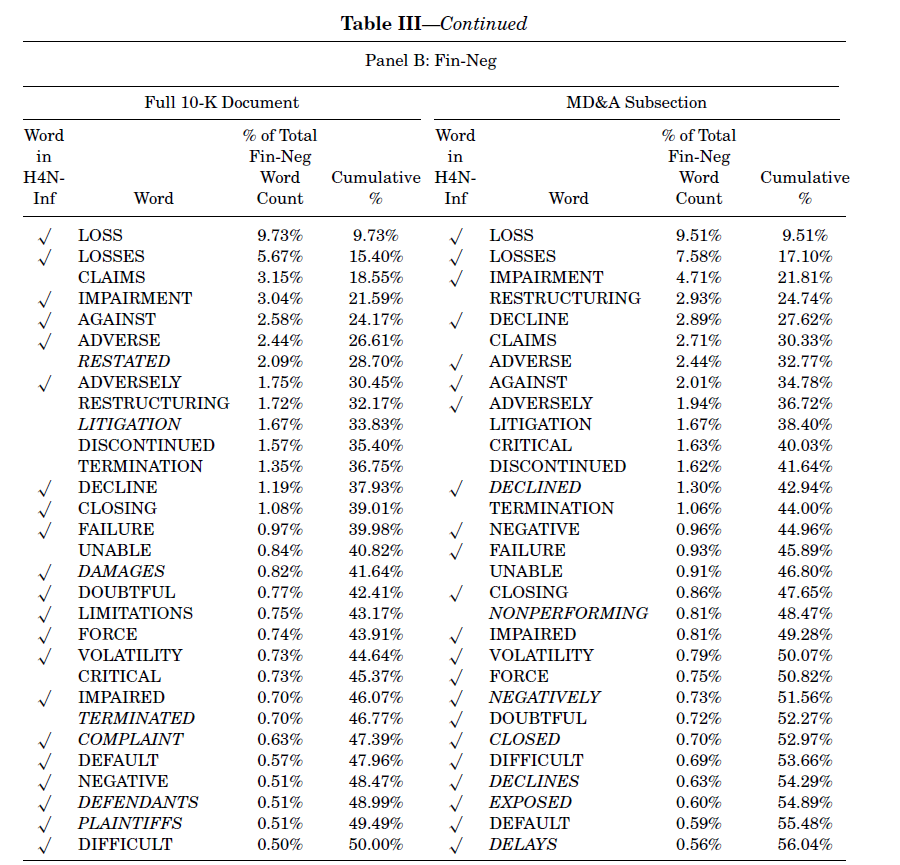

In [3]:
# hide
display(Image("images/loughran_table3.png", width=500))

The following table shows that sentiment words reprenet about 1% of all words. In these sections, there are more words deemed negative (mean=1.39%) than positive (mean=0.75%). 

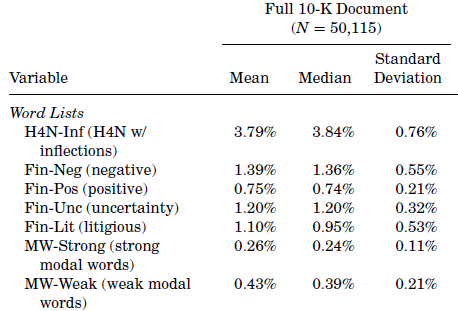

In [4]:
# hide
display(Image("images/l7_loughran.PNG", width=350))

The following table shows the predictibility of sentiment for 4-day forward value-weighted excess return (1994-2008). More precisely, the `Fin-Neg` (negative) sentiment predicts returns with a t-stat from -2.64 to -3.11 after controlling for risk factors. 

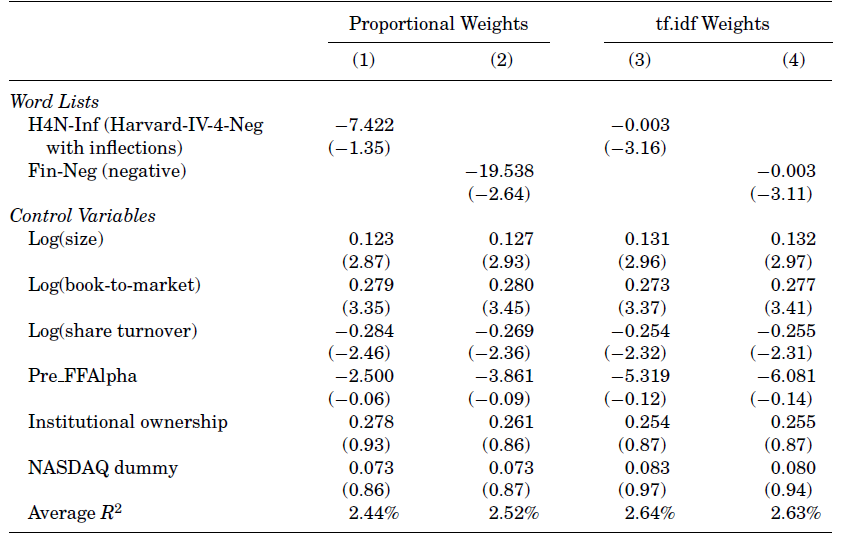

In [5]:
# hide
display(Image("images/loughran_table4.png", width=500))

The table below shows the same results for several word dictionaries. 

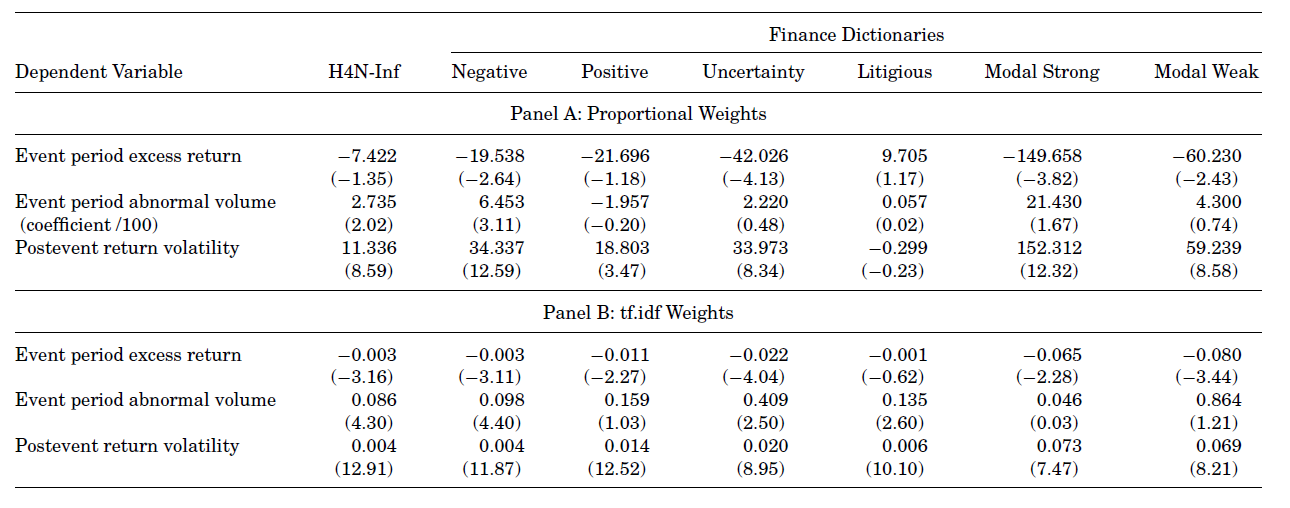

In [6]:
# hide
display(Image("images/loughran_table6.png", width=700))

## Learning-based sentiment

Jegadessh and Wu (2013) discuss how to fit word weights to better identify terms that drive returns.

- The idea is to identify sentiment words associated to significant return moves (either positive or negative) when firm file 10Ks with the SEC. 


Learning for document $d$: 
$$
r_{d,t\rightarrow t+3} = a + \sum_{v \in LM} b_v \frac{count_{d,v}}{length_v} + e 
$$
where the terms $v$ are in the base sentiment vocabulary $LM$ from  Loughran and McDonalds. 

Out-of-sample forecast: 
$$
Score_d = \sum_v \left(\frac{b_v - \bar{b}}{\sqrt{Var(b_j)}} \right) \frac{cound_{d,v}}{length_d}
$$

$$
r_{d,t+5\rightarrow t+w} = \alpha + \beta Score_d  + \epsilon 
$$
where the statistical significance of $\beta$ is evaluated using Fama-MacBeth statistics. 


The table below shows the most impactful words from the regressions. 

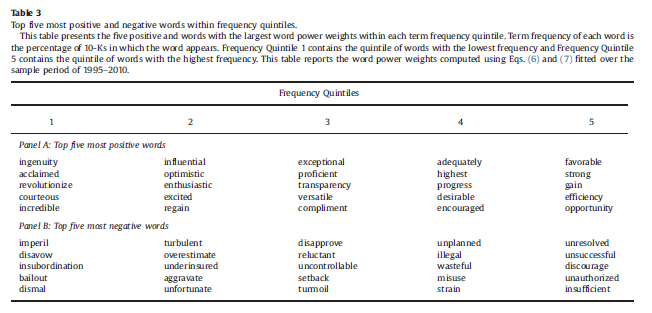

In [7]:
# hide
display(Image("images/Jegadeesh_1.PNG", width=700))

The table below shows taht the words identified in the regressions are not the same as the one with high `tfidf` weights.

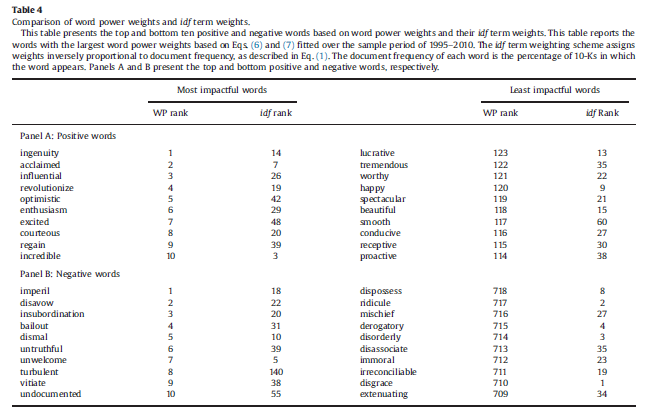

In [8]:
# hide
display(Image("images/Jegadeesh_2.PNG", width=700))

The table shows that the learned sentiment (as the `WP` or word power score) predicts 4-day forward returns -- even after controlling for known risk factors.

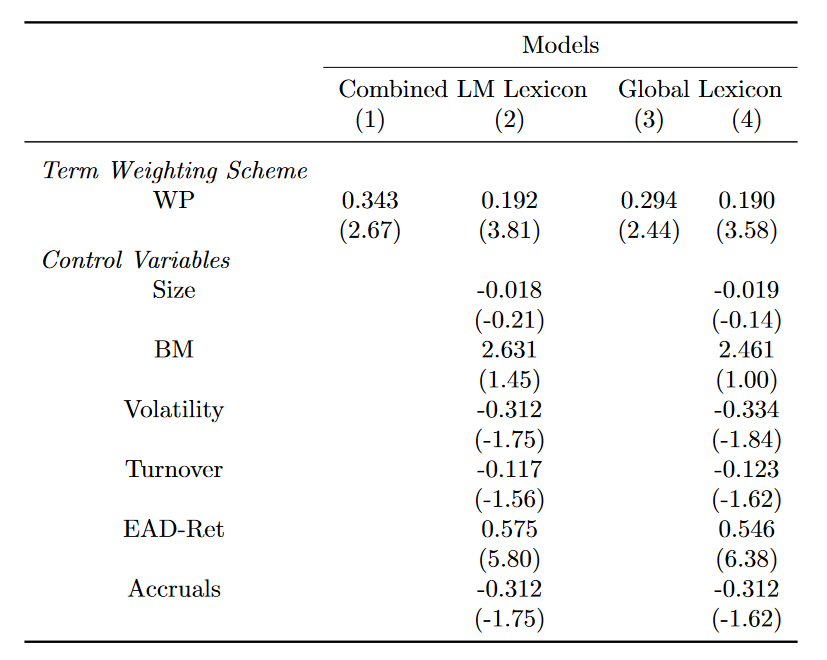

In [9]:
# hide
display(Image("images/Jegadeesh_results.png", width=500))

## 10-Ks

We use the 10-K/10-Q summary file from the McDonalds data repository to test some insights from the Loughran-McDonalds paper. The sentiment metric is: 
- sentiment = (#positive - #negative)/#words

In [10]:
from skfin.datasets_ import load_10X_summaries, load_sklearn_stock_returns
from skfin.dataloaders.constants.mappings import mapping_10X
from skfin.metrics import sharpe_ratio

ret = load_sklearn_stock_returns(cache_dir="data")

INFO:skfin.dataloaders.cache:Loading from cache : data/sklearn_returns.parquet


In [11]:
df = load_10X_summaries()

INFO:skfin.dataloaders.cache:Loading from cache : data/Loughran-McDonald_10X_Summaries_1993-2021.csv


In [12]:
df.columns

Index(['CIK', 'FILING_DATE', 'ACC_NUM', 'CPR', 'FORM_TYPE', 'CoName', 'SIC',
       'FFInd', 'N_Words', 'N_Unique_Words', 'N_Negative', 'N_Positive',
       'N_Uncertainty', 'N_Litigious', 'N_StrongModal', 'N_WeakModal',
       'N_Constraining', 'N_Negation', 'GrossFileSize', 'NetFileSize',
       'NonTextDocTypeChars', 'HTMLChars', 'XBRLChars', 'XMLChars',
       'N_Exhibits'],
      dtype='object')

In [13]:
sentiment_func = lambda x: (x.N_Positive - x.N_Negative) / x.N_Words

sent = (
    pd.concat(
        {
            k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]
            .loc["2002-01-01" : ret.index[-1]]
            .pipe(sentiment_func)
            for k, v in mapping_10X.items()
        }
    )
    .groupby(level=[0, 1])
    .mean()
)

From the sentiment metrics, we follows the steps to contruct a predictor: 

- take the sentiment difference from on filing to the previous to measure improvement or deterioration (and remove biases)
- forward-fill the value for one-month (=21 business days) to have an active position over a limited window
- remove the cross-sectional mean (and standardise) so that the predictor have long-short risk-managed positions. 

In [14]:
pred = (
    sent.sort_index(level=[0, 1])
    .groupby(level=0)
    .transform("diff")
    .unstack(level=0)
    .resample("B")
    .last()
    .ffill(limit=21)
    .pipe(lambda x: x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0))
    .reindex(ret.index)
)

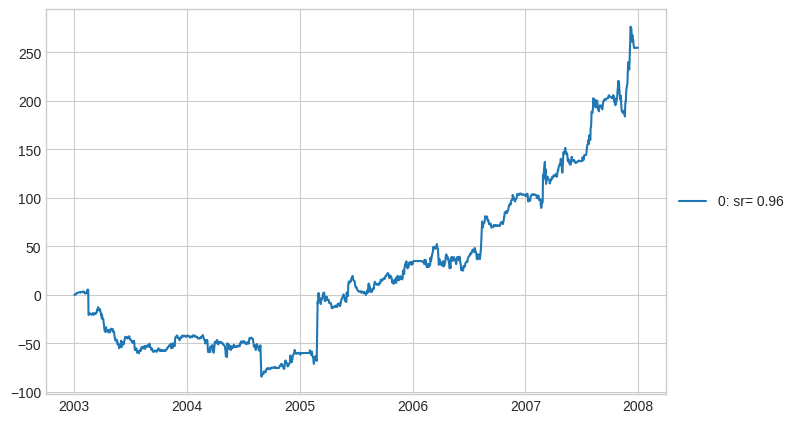

In [15]:
line(pred.shift(2).mul(ret).sum(axis=1), cumsum=True)

Interesting to note that over this period, two firms contribute disportionately to the pnl -- Apple and Goldman Sachs.

In [16]:
pred.shift(2).mul(ret).dropna(how="all", axis=1).sum().pipe(
    lambda x: pd.concat([x.nlargest(), x.sort_values(ascending=False).tail(5)])
).rename("Stock-level pnl contribution").to_frame()

,Stock-level pnl contribution
AAPL,109.887671
GS,97.708109
WFC,27.697014
YHOO,26.637468
DELL,25.705414
TWX,-9.531156
AIG,-10.113330
GD,-21.962501
BAC,-27.134267
MSFT,-35.148272


To assess the alpha decay, the graph below shows the sharpe ratio when the predictor is lagged (or led) by multiple business days. 

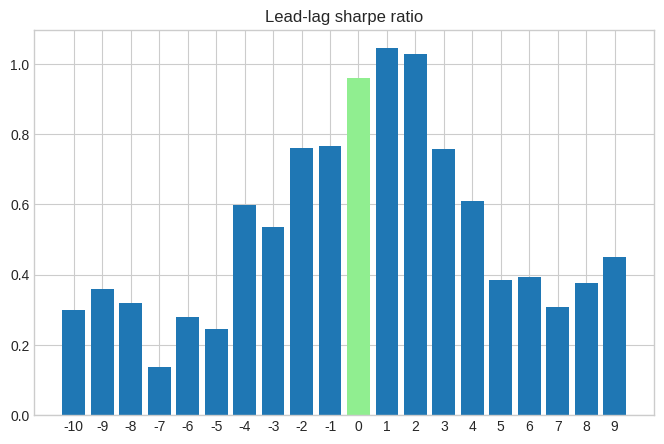

In [17]:
bar(
    {
        i: pred.shift(2 + i).mul(ret).sum(axis=1).pipe(sharpe_ratio)
        for i in range(-10, 10)
    },
    sort=False,
    baseline=0,
    title="Lead-lag sharpe ratio",
)

We can test different sentiment construct as shown in the graph below. 

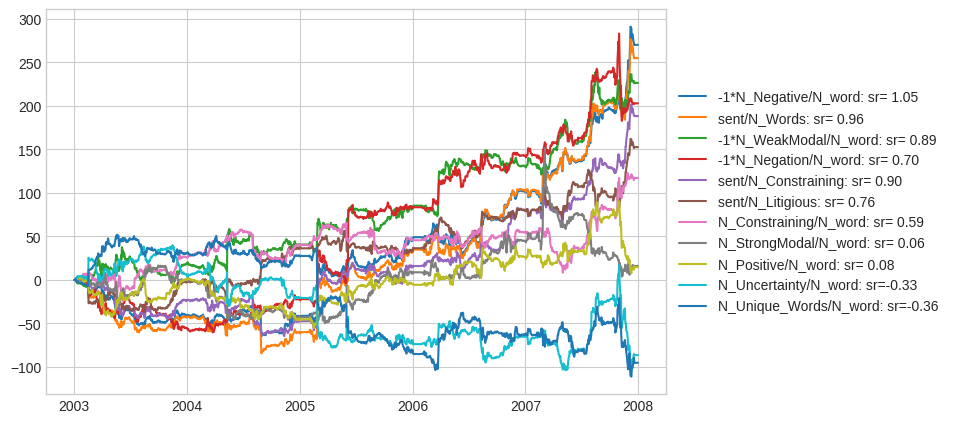

In [18]:
pnls_ = {}
for c in ["N_Litigious", "N_Constraining", "N_Words"]:
    sentiment_func_ = lambda x: (x.N_Positive - x.N_Negative) / x[c]
    sent_ = (
        pd.concat(
            {
                k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]
                .loc["2002-01-01" : ret.index[-1]]
                .pipe(sentiment_func_)
                for k, v in mapping_10X.items()
            }
        )
        .groupby(level=[0, 1])
        .mean()
    )

    pred_ = (
        sent_.sort_index(level=[0, 1])
        .groupby(level=0)
        .transform("diff")
        .unstack(level=0)
        .resample("B")
        .last()
        .ffill(limit=21)
        .pipe(lambda x: x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0))
        .reindex(ret.index)
    )

    pnls_[f"sent/{c}"] = pred_.shift(2).mul(ret).sum(axis=1)


for c in ["N_Negative", "N_Negation", "N_WeakModal"]:
    sentiment_func_ = lambda x: -1 * x[c] / x.N_Words
    sent_ = (
        pd.concat(
            {
                k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]
                .loc["2002-01-01" : ret.index[-1]]
                .pipe(sentiment_func_)
                for k, v in mapping_10X.items()
            }
        )
        .groupby(level=[0, 1])
        .mean()
    )

    pred_ = (
        sent_.sort_index(level=[0, 1])
        .groupby(level=0)
        .transform("diff")
        .unstack(level=0)
        .resample("B")
        .last()
        .ffill(limit=21)
        .pipe(lambda x: x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0))
        .reindex(ret.index)
    )

    pnls_[f"-1*{c}/N_word"] = pred_.shift(2).mul(ret).sum(axis=1)


for c in [
    "N_Unique_Words",
    "N_Positive",
    "N_Uncertainty",
    "N_StrongModal",
    "N_Constraining",
]:
    sentiment_func_ = lambda x: x[c] / x.N_Words
    sent_ = (
        pd.concat(
            {
                k: df.loc[lambda x: x.CoName.isin(v if isinstance(v, list) else [v])]
                .loc["2002-01-01" : ret.index[-1]]
                .pipe(sentiment_func_)
                for k, v in mapping_10X.items()
            }
        )
        .groupby(level=[0, 1])
        .mean()
    )

    pred_ = (
        sent_.sort_index(level=[0, 1])
        .groupby(level=0)
        .transform("diff")
        .unstack(level=0)
        .resample("B")
        .last()
        .ffill(limit=21)
        .pipe(lambda x: x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0))
        .reindex(ret.index)
    )

    pnls_[f"{c}/N_word"] = pred_.shift(2).mul(ret).sum(axis=1)
line(pnls_, cumsum=True)